In [1]:
import numpy as np
import matplotlib.pyplot as plt

Mini-Project 1, Fong Ken Rui, A0230385J

# Derivations

## Equation to solve

Given a steady-state situation, $\dfrac{\partial T}{\partial t} = 0$. Then:

$
\dfrac{\partial}{\partial d} \left( A_h  \dfrac{\partial T}{\partial d} \right) = \dfrac{1}{C_p}\dfrac{\partial I}{\partial d}
$

Since $A_h$ has functional dependence on $d$, we expand the left hand side with the product rule:

$
\dfrac{\partial A_h }{\partial d}  \dfrac{\partial T}{\partial d} + A_h \dfrac{\partial^2 T}{\partial d^2}  = \dfrac{1}{C_p}\dfrac{\partial I}{\partial d}
$

$
\left[ \dfrac{\partial A_h }{\partial d}  \dfrac{\partial }{\partial d} + A_h \dfrac{\partial^2 }{\partial d^2} \right] T  = \dfrac{1}{C_p}\dfrac{\partial I}{\partial d}
$

Our goal now is to approximate the linear operator on the left hand side as a finite difference matrix.



## Approximate the derivative operators

Here we use the central difference approximation for both the first and second derivatives, which both have a leading error term of $O(\Delta^2)$.

$
\dfrac{\partial^2 T}{\partial d^2}(d_i) \approx \dfrac{1}{\Delta^2} (T(d_{i+1}) -2T(d_i) + T(d_{i-1}) )
$

$
\dfrac{\partial T}{\partial d}(d_i) \approx \dfrac{1}{2 \Delta} (T(d_{i+1}) - T(d_{i-1}) )
$

Rearranging the terms into a linear equation:

$
\left[ \dfrac{\partial A_h }{\partial d}  \dfrac{\partial }{\partial d} + A_h \dfrac{\partial^2 }{\partial d^2} \right] T(d_i) = \dfrac{\partial A_h }{\partial d}(d_i) \times \dfrac{1}{2 \Delta} (T(d_{i+1}) - T(d_{i-1}) ) + A_h(d_i) \times \dfrac{1}{\Delta^2} (T(d_{i+1}) -2T(d_i) + T(d_{i-1}) ) 
$

$
\left[ \dfrac{\partial A_h }{\partial d}  \dfrac{\partial }{\partial d} + A_h \dfrac{\partial^2 }{\partial d^2} \right] T(d_i) = \left[\dfrac{A_h}{\Delta^2}(d_i) - \dfrac{1}{2 \Delta} \dfrac{\partial A_h}{\partial d}(d_i) \right] T(d_{i-1}) + \left[ -\dfrac{2 A_h(d_i)}{\Delta^2} \right] T(d_i) + \left[ \dfrac{A_h}{\Delta^2}(d_i) + \dfrac{1}{2 \Delta} \dfrac{\partial A_h}{\partial d}(d_i) \right]T(d_{i+1})
$

The above equation can be reformulated as a matrix equation with a tridiagonal matrix.


## Find the coefficient functions

Since the analytic expression for $A_h$ is given, $\dfrac{\partial A_h}{\partial d}$ can be derived analytically.

$\dfrac{\partial A_h}{\partial d} = [-A_{dip} - 0.5(A_{max} - A_{depth} - A_{dip}(d-h))]\exp(-0.5(d-h))$

This function needs to be evaluated for all discrete points $d_i$.

## Find the RHS function

The function $I(d)$ is of the form $I(d) = I_s \exp(- d/\alpha)$, thus the derivative is $ -\dfrac{1}{\alpha} I_s \exp(- d/\alpha)$.

$I_s$ is the intensity of insolation at the surface, given by $100 Wm^{-2} \times (1-albedo) \times (1 - \beta)$.

The function $\dfrac{1}{C_p}\dfrac{\partial I}{\partial d}$ needs to be evaluated for all discrete points $d_i$.

## Boundary Conditions

There are two Dirichlet boundary conditions $T(d=0) = -1$ and $T(d=200) = -2$.

## Summary



The equations to be solved are:

$T(d=0) = -1$

$T(d=200) = -2$

For $0 < d_i < 200 $:

$
\left[\dfrac{A_h}{\Delta^2}(d_i) - \dfrac{1}{2 \Delta} \dfrac{\partial A_h}{\partial d}(d_i) \right] T(d_{i-1}) + \left[ -\dfrac{2 A_h(d_i)}{\Delta^2} \right] T(d_i) + \left[ \dfrac{A_h}{\Delta^2}(d_i) + \dfrac{1}{2 \Delta} \dfrac{\partial A_h}{\partial d}(d_i) \right]T(d_{i+1}) = \dfrac{1}{C_p}\dfrac{\partial I}{\partial d}(d_i)
$

This is can be formulated as a matrix equation $Ax = b$.

# Simulation

## Base Case

In [2]:
# Define our simulation parameters
parameters = {
'A_max' : 1e-2, # m^2 s^-1
'A_depth' : 1e-4, # m^2 s^-1
'A_dip' : 1.5e-3, # m^2 s^-1
'h' : 10, # m
'alphainv' : 1/10, # 1/alpha, m
'I_s' : 100 * 0.9 * (1 - 0.5), # Insolation at the surface
'C_p' : 4e6, #J kg C^-1
}


In [3]:
def main_script(N, par):
    delta = 200/N
    A_max = par['A_max'] 
    A_depth = par['A_depth']
    A_dip = par['A_dip']
    h = par['h']
    alphainv = par['alphainv']
    I_s = par['I_s']
    C_p = par['C_p']
    
    def partialI(d):
        return -alphainv * I_s * np.exp(-alphainv*d) 
    
    def A_h(d):
        if d <= h:
            return A_max
        if d > h:
            A_h = A_depth + (A_max - A_depth - A_dip*(d-h)) * np.exp( -0.5*(d-h))
            if A_h < 0:
                raise ValueError("Value of A_h is negative")
            return A_h
    
    def partial_A_h(d):
        if d <= h:
            return 0 
        if d > h:
            return (-A_dip - 0.5 * ( A_max - A_depth - A_dip*(d-h) )) * np.exp(-0.5*(d-h))

    def get_stencil(d_i):
        term1 = A_h(d_i)/(delta**2) - partial_A_h(d_i)/(2*delta)
        term2 = -2 * A_h(d_i)/(delta**2)
        term3 = A_h(d_i)/(delta**2) + partial_A_h(d_i)/(2*delta)
        return np.array((term1, term2, term3))


    def generate_matrix(N):
        d_array = np.linspace(start=0, stop=200, num=N+1) # discretized domain
        matrix = np.zeros((N+1, N+1))
        for i in range(1, N):
            stencil = get_stencil(d_array[i])
            #print("depth=", d_array[i], "stencil=",stencil)
            matrix[i, i-1:i+2] = stencil
    
        # Boundary conditions
        matrix[0, 0] = 1
        matrix[-1, -1] = 1
        return d_array, matrix

    def generate_b_vector(d_array):
        b_vector = partialI(d_array)/ C_p
        # Set boundary conditions
        b_vector[0] = -1 # Temperature at surface
        b_vector[-1] = -2 # Temperature at d=200m
        return b_vector

    d_array, matrix = generate_matrix(N)
    b_vector = generate_b_vector(d_array)
    solution = np.linalg.solve(matrix, b_vector)
    return matrix, solution, b_vector, d_array


In [4]:
results = {}
for N in (50, 200, 1000, 5000):
    results[N] = {}
    matrix, solution, b_vector, d_array = main_script(N, parameters)
    results[N]['matrix'] = matrix
    results[N]['solution'] = solution
    results[N]['b_vector'] = b_vector
    results[N]['d_array'] = d_array

In [5]:
for N in (50, 200, 1000, 5000):
    matrix = results[N]['matrix'] 
    print(f'N={N}', 'Cond=', np.linalg.cond(matrix))
    print(results[N]['b_vector'][1])

N=50 Cond= 35882496.526802614
-7.541100517900943e-07
N=200 Cond= 35823132.06626943
-1.0179420952904545e-06
N=1000 Cond= 37669321.96672205
-1.1027235074700996e-06
N=5000 Cond= 895570771.75006
-1.1205089880119905e-06


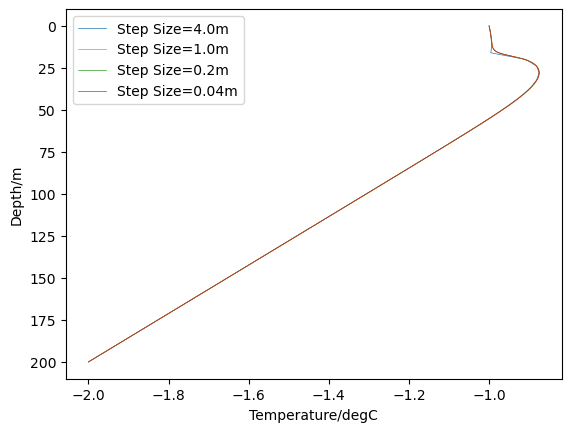

In [6]:
for N in (50, 200, 1000, 5000):
    solution = results[N]['solution']
    d_array = results[N]['d_array']
    plt.plot(solution, d_array, label=f'Step Size={200/N}m', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel("Temperature/degC")
plt.ylabel("Depth/m")
plt.legend()

The profile seems to converge to the same answer with decreasing step size, therefore we can be reasonably confident that the numerical scheme used is suitable. The profile features a constant temperature profile up to around 10m in depth. This corresponds to the well-mixed surface layer with homogenous temperature. A Near Surface Temperature Maximum (NSTM) is observed at depths of around 27m.

## Vary mixing profiles

### Vary A_max

In [7]:
# Define our simulation parameters
parameters = {
'A_max' : None, # m^2 s^-1
'A_depth' : 1e-4, # m^2 s^-1
'A_dip' : 1.5e-3, # m^2 s^-1
'h' : 10, # m
'alphainv' : 1/10, # 1/alpha, m
'I_s' : 100 * 0.9 * (1 - 0.5), # Insolation at the surface
'C_p' : 4e6, #J kg C^-1
}
N = 5000

In [8]:
results = {}
for A_max in (10, 1, 1e-1, 1e-2):
    parameters['A_max'] = A_max
    results[A_max] = {}
    try:
        matrix, solution, b_vector, d_array = main_script(N, parameters)
    except ValueError as error:
        print(error, ',A_max=', A_max)
    results[A_max]['matrix'] = matrix
    results[A_max]['solution'] = solution
    results[A_max]['b_vector'] = b_vector
    results[A_max]['d_array'] = d_array

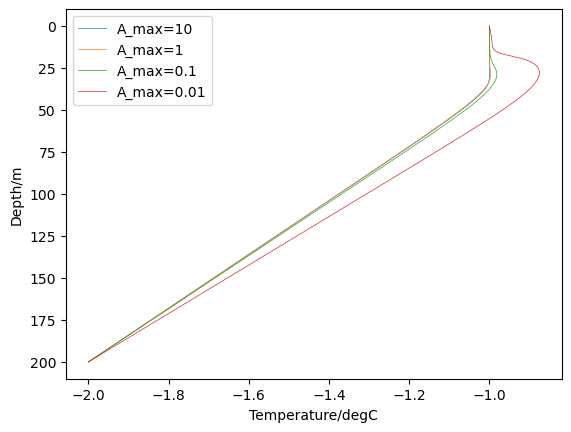

In [9]:
for A_max in (10, 1, 1e-1, 1e-2):
    solution = results[A_max]['solution']
    d_array = results[A_max]['d_array']
    plt.plot(solution, d_array, label=f'A_max={A_max}', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel("Temperature/degC")
plt.ylabel("Depth/m")
plt.legend()

A_max determines the strength of the mixing coefficient in the well-mixed surface layer. As $A_h$ is continuous, this also increases the mixing coefficient for the region beneath the surface layer, where the NSTM occurs. Therefore, as A_max increases, the top layer becomes well-mixed and more homogenous, and the NSTM flattens or even dissapears entirely. Conversely, as A_max decreases, mixing processes are less dominant near the surface layer, allowing a the ocean to become highly stratified with a strong NSTM peak.

### Vary A_depth

In [10]:
# Change some of the simulation parameters
parameters = {
'A_max' : 1e-2, # m^2 s^-1
'A_depth' : None, # m^2 s^-1
'A_dip' : 1.5e-3, # m^2 s^-1
'h' : 10, # m
'alphainv' : 1/10, # 1/alpha, m
'I_s' : 100 * 0.9 * (1 - 0.5), # Insolation at the surface
'C_p' : 4e6, #J kg C^-1
}
N = 5000

In [11]:
results = {}
for A_depth in (1e-1, 1e-2, 1e-3, 1e-4):
    parameters['A_depth'] = A_depth
    results[A_depth] = {}
    try:
        matrix, solution, b_vector, d_array = main_script(N, parameters)
    except ValueError as error:
        print(error, ',A_depth=', A_depth)
    results[A_depth]['matrix'] = matrix
    results[A_depth]['solution'] = solution
    results[A_depth]['b_vector'] = b_vector
    results[A_depth]['d_array'] = d_array

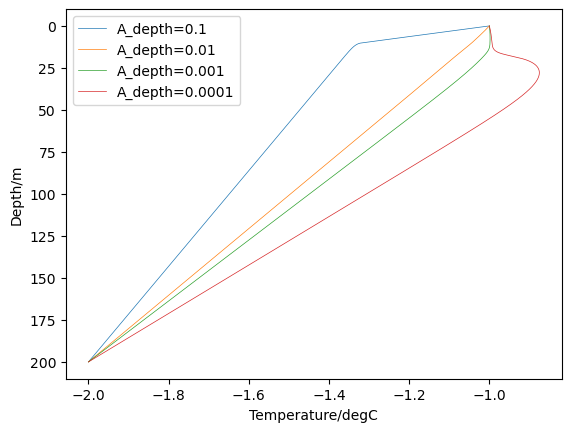

In [12]:
for A_depth in (1e-1, 1e-2, 1e-3, 1e-4):
    solution = results[A_depth]['solution']
    d_array = results[A_depth]['d_array']
    plt.plot(solution, d_array, label=f'A_depth={A_depth}', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel("Temperature/degC")
plt.ylabel("Depth/m")
plt.legend()

A_depth determines the mixing strength at the region below the surface layer. As A_depth decreases, the subsurface layers become more stratified, resulting in a stronger NSTM. As A_depth increases, the mixing strength approaches that of the well-mixed surface layer, and thus the temperature profile approaches a linear curve. For A-depth=0.1, the mixing strength of the surface layer becomes weaker than that of the subsurface layer (which cannot be the case), resulting in an unphysical profile.

### Vary h

In [13]:
# Change some of the simulation parameters
parameters = {
'A_max' : 1e-2, # m^2 s^-1
'A_depth' : 1e-4, # m^2 s^-1
'A_dip' : 1.5e-3, # m^2 s^-1
'h' : None, # m
'alphainv' : 1/10, # 1/alpha, m
'I_s' : 100 * 0.9 * (1 - 0.5), # Insolation at the surface
'C_p' : 4e6, #J kg C^-1
}
N = 5000

In [14]:
results = {}
for h in (2, 5, 10, 20, 50):
    parameters['h'] = h
    results[h] = {}
    matrix, solution, b_vector, d_array = main_script(N, parameters)
    results[h]['matrix'] = matrix
    results[h]['solution'] = solution
    results[h]['b_vector'] = b_vector
    results[h]['d_array'] = d_array

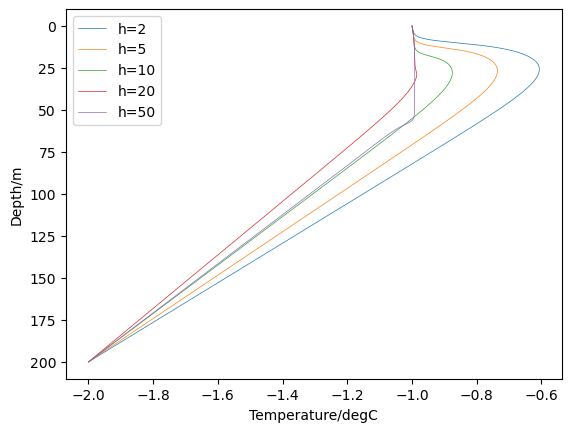

In [15]:
for h in (2, 5, 10, 20, 50):
    solution = results[h]['solution']
    d_array = results[h]['d_array']
    plt.plot(solution, d_array, label=f'h={h}', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel("Temperature/degC")
plt.ylabel("Depth/m")
plt.legend()

The parameter h determines the thickness of the of the surface layer. As expected, the thickness of the flat portion of the temperature profile correlates with the parameter h. In addition, the greater the thickness of the surface layer, the flatter the NSTM, until it dissapears entirely for h=50. This is because in order to produce the NSTM, there must be sufficient insolation penetrating the stratified layer of the ocean to warm up the layers and produce a local temperature maximum. With all else held constant, the thicker the surface layer, the further down the stratified subsurface layer, and thus the intensity of light received is lower.

## Vary alpha

In [16]:
# Change some of the simulation parameters
parameters = {
'A_max' : 1e-2, # m^2 s^-1
'A_depth' : 1e-4, # m^2 s^-1
'A_dip' : 1.5e-3, # m^2 s^-1
'h' : 10, # m
'alphainv' : None, # 1/alpha, m
'I_s' : 100 * 0.9 * (1 - 0.5), # Insolation at the surface
'C_p' : 4e6, #J kg C^-1
}
N = 5000

In [17]:
results = {}
for alphainv in (2, 1, 1/5, 1/10, 1/20):
    parameters['alphainv'] = alphainv
    results[alphainv] = {}
    matrix, solution, b_vector, d_array = main_script(N, parameters)
    results[alphainv]['matrix'] = matrix
    results[alphainv]['solution'] = solution
    results[alphainv]['b_vector'] = b_vector
    results[alphainv]['d_array'] = d_array

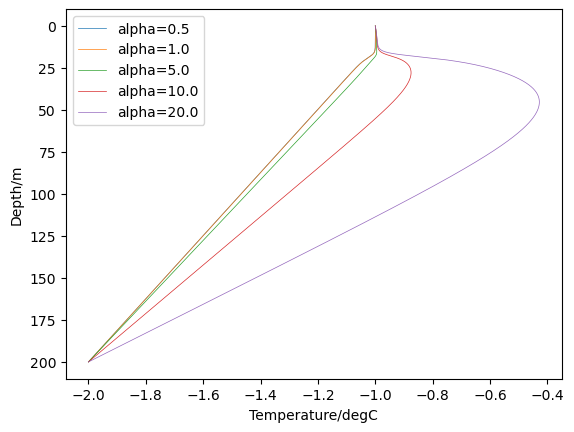

In [18]:
for alphainv in (2, 1, 1/5, 1/10, 1/20):
    solution = results[alphainv]['solution']
    d_array = results[alphainv]['d_array']
    plt.plot(solution, d_array, label=f'alpha={1/alphainv}', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel("Temperature/degC")
plt.ylabel("Depth/m")
plt.legend()

Alpha is the e-folding depth of light intensity, and essentially describes how transparent or opaque the ocean is to light. Higher e-folding depth corresponds to more transparent oceans and vice versa. Thus, for higher alpha, the peak of the NSTM shifts downwards as light is penetrating deeper into the ocean depths, and the NSTM profile widens as a larger portion of the stratified subsurface layers are absorbing light. 

## Vary Ice Fraction

In [19]:
# Change some of the simulation parameters
parameters = {
'A_max' : 1e-2, # m^2 s^-1
'A_depth' : 1e-4, # m^2 s^-1
'A_dip' : 1.5e-3, # m^2 s^-1
'h' : 10, # m
'alphainv' : 1/10, # 1/alpha, m
'I_s' : None, #100 * 0.9 * (1 - 0.5), # Insolation at the surface
'C_p' : 4e6, #J kg C^-1
}
N = 5000

In [20]:
results = {}
for beta in (0, 0.2, 0.5, 0.7, 0.9):
    I_s = 100 * 0.9 * (1-beta)
    parameters['I_s'] = I_s
    results[I_s] = {}
    matrix, solution, b_vector, d_array = main_script(N, parameters)
    results[I_s]['matrix'] = matrix
    results[I_s]['solution'] = solution
    results[I_s]['b_vector'] = b_vector
    results[I_s]['d_array'] = d_array

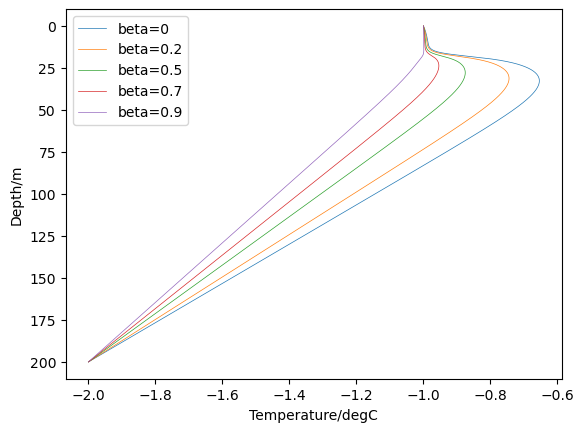

In [21]:
for beta in (0, 0.2, 0.5, 0.7, 0.9):
    I_s = 100 * 0.9 * (1-beta)
    solution = results[I_s]['solution']
    d_array = results[I_s]['d_array']
    plt.plot(solution, d_array, label=f'beta={beta}', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xlabel("Temperature/degC")
plt.ylabel("Depth/m")
plt.legend()

Ice fraction controls how much insolation is received at the ocean surface. As expected, the NSTM is stronger for low ice fraction (and thus higher insolation) and vice versa. The position of the NSTM only shifts slightly, because although the overall intensity of light is higher by a multiplicative factor, the e-folding depth is the same and the exponential decay dominates. 